# Assignment 3

## Learning Goals
After successfully completing this assignment, you should be able to:
- differentiate between classification and regression tasks
- learn a hypothesis for binary classification by using logistic regression and evaluate it
- evaluate a hypothesis for classification problems by using diferrent metrics
- learn a hypothesis for multi-class classification problems (more than two different label values) and evaluate it

## General Instructions
- Jupyter notebook is supposed to be run cell by cell in order, please do not skip any code cell, this will cause some errors. Also running cells back and forth sometimes might also incur errors. If you feel you lost your track, you can click "Kernel->Restart" from the menu to restart the process.
- Please DO NOT change the metadata of any cell, cells for demo and instructions are not editable.
- Please DO NOT change the order of solution cell and test cell, you will lost points if the order is changed.
- You can copy lines of code from cells that are not editable, but please DO NOT copy and paste them as cells, this may incur validation error. 
- You can add extra cells or code to help double-check your solution, but please make sure that variables required by tasks are not overwritten, or just delete those extra cells before submitting.
- Please DO NOT change file names in you submission, renamed files can not be recognized by the grading system.
- Reading the documentation of Python libraries is always a good practice, all the Python libraries (Numpy, Pandas, Sklearn,etc.) we utilized in this course provide very well organized documentation for each method/class/function.

In [2]:
%config Completer.use_jedi = False  # enable code auto-completion
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  #data visualization library
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix  # evaluation metrics

# Dataset 
We use the same data source as Assignment2: weather recordings from the [Finnish Meteorological Institute](https://en.ilmatieteenlaitos.fi/). For your convenience we have already downloaded and stored these recordings in the csv file `FMIData_Assignment3.csv`.  The code snippet below reads in the weather recordings from this file and store them in a Pandas `DataFrame` with the name `df`. 

In [3]:
# Read in the data stored in the file 'FMIData_Assignment3.csv'
# Clean the dataframe

df = pd.read_csv('FMIData_Assignment3.csv')
df.drop(columns=['Time zone','Precipitation amount (mm)','Snow depth (cm)','Air temperature (degC)',\
                 'Ground minimum temperature (degC)'],inplace=True)  # drop unrelevant columns

df.columns =['year','m','d','time','max temperature','min temperature'] # rename columns 

# Print the first 5 rows of the DataFrame 'df'
df.head(5)

,year,m,d,time,max temperature,min temperature
0,2020,1,1,00:00,3.4,-2.6
1,2020,1,1,06:00,NaN,NaN
2,2020,1,2,00:00,5.1,1.8
3,2020,1,2,06:00,NaN,NaN
4,2020,1,3,00:00,5.7,4.3


Each row of dataframe `df` contains a weather recording along with a time-stamp. We will use only weather recording with time-stamp `00:00`. For the $i$-th day, we use the value in the column "min temperature" as the feature $x^{(i)}$. The label $y^{(i)}$ of the $i$-th day (datapoint) is determined by the value $\text{maxtmp}^{(i)}$ in the column "max temperature". In particular, we define the label $y^{(i)}$ of the $i$-th day to be equal to 1 if the corresponding weather recording has a positive entry in  the column "max temperature", otherwise we define the label to be $y^{(i)}=0$. More formally, $y^{(i)}=1$ if $\text{maxtmp}^{(i)} > 0$ and $y^{(i)}=0$ if $\text{maxtmp}^{(i)} \leq{0}$. This can be easily realized by using the Pandas method [pd.cut()](https://pandas.pydata.org/docs/reference/api/pandas.cut.html).

In [4]:
# Select only weather recordings whose property 'time' is equal to `00:00`
FMIRawData = df[df['time'] == '00:00']

minvalue = FMIRawData['max temperature'].min() # minimum value of the column 'max temperature'
maxvalue = FMIRawData['max temperature'].max() # maximum value of the column 'max temperature'

if 'binarized max temperature' in FMIRawData.columns:  # delete existing 'binarized max temperature' if there is
    FMIRawData = FMIRawData.drop(['binarized max temperature'],axis=1)
    
bi_labels = [0,1] # new labels to be assigned
bi_cut_bins = [minvalue,0,maxvalue] #cutting intervals/criteria [minvalue,0],(0,maxvalue]

# Encode max temperatures to binary labels

binarized_maxtmp = pd.cut(FMIRawData['max temperature'],\
                                                 bins=bi_cut_bins,labels=bi_labels,include_lowest=True)

# Insert a new column "binarized max temperature" to the datafame
# Int 6 is the position where the new column will be inserted to

FMIRawData.insert(6,'binarized max temperature',binarized_maxtmp) 

# Print the first 5 rows of the DataFrame 'FMIRawData',you will see the new column "binarized max temperature"
FMIRawData.head()

,year,m,d,time,max temperature,min temperature,binarized max temperature
0,2020,1,1,00:00,3.4,-2.6,1
2,2020,1,2,00:00,5.1,1.8,1
4,2020,1,3,00:00,5.7,4.3,1
6,2020,1,4,00:00,4.7,0.7,1
8,2020,1,5,00:00,1.9,-4.9,1


The code snippet below generates two scatter plots and a histogram to visualise the data points in our dataset. The first scatter plot depicts data points (day) using their corresponding min. and max temperature as coordinates. The second scatter plot depicts data points (days) using their min temperature and label $y$ as coordinates. Finally, a histogram is generated to depict the number of data points for each label value.  We can see that the max temperatures of more than 600 days are above zero, only less than 100 days have max temperature below zero.

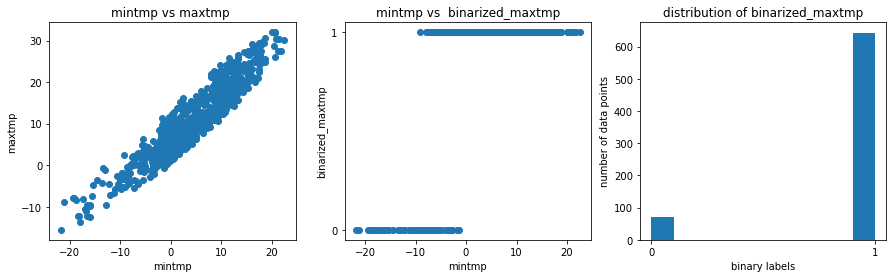

In [5]:
# Visualize data
fig, axes = plt.subplots(1, 3, figsize=(15,4))
axes[0].scatter(FMIRawData['min temperature'],FMIRawData['max temperature']);
axes[0].set_xlabel("mintmp")
axes[0].set_ylabel("maxtmp")
axes[0].set_title("mintmp vs maxtmp ")

axes[1].scatter(FMIRawData['min temperature'],FMIRawData['binarized max temperature']);
axes[1].set_xlabel("mintmp")
axes[1].set_ylabel("binarized_maxtmp")
axes[1].set_yticks([0,1])
axes[1].set_title("mintmp vs  binarized_maxtmp")

axes[2].hist(FMIRawData['binarized max temperature'])
axes[2].set_title('distribution of binarized_maxtmp')
axes[2].set_xlabel("binary labels")
axes[2].set_ylabel('number of data points')
axes[2].set_xticks([0,1])
plt.show()

In the following blocks, we will explore the first classification method we have learnt: **Logistic regression**.

Logistic regression is a ML method that learns the parameters of a linear map $h(x) = w^{T}x$ that is used to classify data points into a finite number of categories or classes. Each class or category is represented by some label value $y$. For the weather data above, the label value $y=0$ means a cold day ($maxtmp \leq{0}$) while the label value $y=1$ means a warm day ($maxtmp >0$). 

There are two basic variants of logistic regression:
 

- Binary logistic regression for data points having binary labels (they belong to one out of two possible classes). Example: Spam or Not

- Multinomial Logistic Regression for data points belonging to one out of three or more categories without ordering. Example: Predicting which color is preferred more (Green, Yellow, Pink)


<div class=" alert alert-warning">

# Student Task A3.1

1. Fit logistic regression model
    - scikit-learn's [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) class
    - Just like linear regression you will
        1. Create a classifier object that represents a combination of hypothesis space (linear maps) and loss function (logistic loss)
        2. Call the fit method
        3. Call the predict method
    
    
2. Calculate Accuracy
   
    Use the `accuracy` metric to evaluate the model, the function [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) has been imported for you in the beginning of this notebook.
    
NOTE: the .fit() function uses the (average) logistic loss to measure the quality of a specific linear map $h(x) = w^{T}x$. The accuracy metric instead is based on the average $0/1$ loss which is easier to interpret but results in a more difficult optimization problem (to be solved by .fit()). 
    
</div> 

In [6]:
# as what we did in assignment2, create the feature matrix X, make sure X.shape==(m,1)
# and create label vector y from 'binarized max temperature', y.shape=(m,)
X = FMIRawData['min temperature'].to_numpy().reshape(-1, 1)
y = FMIRawData['binarized max temperature'].to_numpy()

In [7]:
## create a LogisticRegressor clf_1 and fit the model to the data as:

# YOUR CODE HERE
clf_1 = LogisticRegression(random_state=0)   # initialise a LogisticRegression classifier, use default value for all arguments
clf_1.fit(X, y)       # fit cfl_1 to data 
y_pred = clf_1.predict(X)   # compute predicted labels for training data
accuracy = clf_1.score(X,y) # compute accuracy on the training set
print("accuracy of LogReg : ", accuracy)

## sanity check
assert isinstance(clf_1, LogisticRegression), "please initialise a LogisticRegression classifier"
assert np.isclose(clf_1.coef_,0.65461766), " learnt parameters are incorrect, please check the feature and label"
assert len(y_pred) == len(y), "the lengthe of y_pred is incorrect"

accuracy of LogReg :  0.9621318373071529


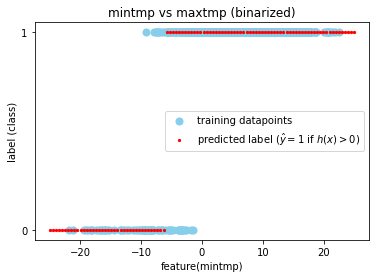

In [8]:
# plot results
fig, ax = plt.subplots()
ax.set_xlabel("feature(mintmp)")
ax.set_yticks([0,1])
ax.set_ylabel('label (class)')
ax.set_title("mintmp vs maxtmp (binarized)")
ax.scatter(X[:,0],y,s=50,c="skyblue",label="training datapoints")
X_fit = np.linspace(-25, 25, 100) 
ax.scatter(X_fit, clf_1.predict(X_fit.reshape(-1, 1)),color='r',s=5,label='predicted label ($\hat{y}=1$ if $h(x) > 0$)') 
ax.legend()
plt.show()

In [9]:
# this cell is for tests


# Evaluation Metrics for Classification Models
Now, you have successfully built your classification model and evaluated your model with the most commonly used  metric `accuracy`. Accuracy is defined as the ratio of the number of correct predictions made by the model over all kinds of predictions made. Note that the accuracy is given by $1 - (1/m) \sum_{i=1}^{m} L(.)$ with $L$ being the 0/1 loss (see Sec. 2.3 of [course book](https://github.com/alexjungaalto/MachineLearningTheBasics/blob/master/MLBasicsBook.pdf)).


You may have noticed that the dataset used in task A3.1 is imbalanced in the sense of a significantly varying frequency of different categories. In particular, there have been much more data points with $y^{(i)} =1$ compared to data points with $y^{(i)} = 0$. If you created the logistic model correctly, you have reached a decent accuracy of around 96%, however, note that you can easily get training accuracy around 90% by always predicting max temperature being above zero. In practice, the situation could be even more extreme. For example, when you want to build a classifier for a medical diagnoses of a rare but fatal disease with a very low incidence 0.1%, you can get an accuracy 99.9% without any effort (just by always predicting "no disease"), but the cost of failing to diagnose the disease of a sick person is dire. This is why we will use different types of evaluation metrics to measure the performance of a hypothesis in classification problems. 

Scikit-learn provides multiple metrics, such as [precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score), [recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score), [accurcy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) and [f1-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score). These more fine-grained performance measures can be obtained from the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). Confusion matrix, also known as an error matrix, is a K x K matrix used for evaluating the performance of a classification model, where K is the number of label classes. The matrix compares the true label values with those predicted by the model. The $k$-th row and $l$-th column entry of confusion matrix indicates the number of samples with true label being $k$-th class and predicted label being $l$-th class. It gives a overall view of how well the model is performing and what kinds of errors it is making.

This is the confusion matrix for a binary classification model:
TN: true negative, FN: false negative, TP: true positive, FP: false positive


<p> 
<img src="con_mat.png" width="500" height="350">

</p>

<div class=" alert alert-warning">

# Student Task A3.2

Compute confusion matrix to evaluate the performance of the classification model you've just learnt.
The function [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) to create confusion matrix is already imported for you.The input for confusion_matrix() should be true labels and predicted labels
    
    
</div> 

In [10]:
## compute confusion matrix as:
# conf_mat = confusion_matrix(..., ...) # NOTE: please pay attention to the order of arguments, the order matters.

# YOUR CODE HERE
conf_mat = confusion_matrix(y, y_pred)

## sanity check
assert conf_mat.shape == (2,2)
print(conf_mat) #print the confusion matrix

[[ 53  17]
 [ 10 633]]


In [11]:
# this cell is for tests

[Text(0, 0.5, 'below zero'), Text(0, 1.5, 'above zero')]

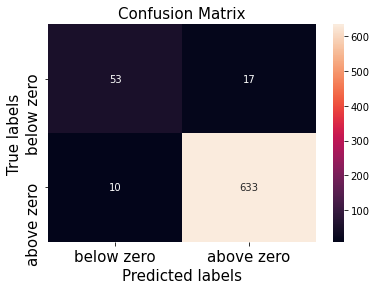

In [12]:
# Visualize the confusion matrix you computed
ax= plt.subplot()

sns.heatmap(conf_mat, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15)
ax.set_ylabel('True labels',fontsize=15)
ax.set_title('Confusion Matrix',fontsize=15)
ax.xaxis.set_ticklabels(['below zero', 'above zero'],fontsize=15)
ax.yaxis.set_ticklabels(['below zero', 'above zero'],fontsize=15)

<div class=" alert alert-warning">

# Student Task A3.3

Compute precision from the confusion matrix you have created, consider max temperature above zero as positive.
    
    
</div> 

In [14]:
## compute precision according to the confusion matrix above, and assign it to the variable 'precision':
# precision = ...

# YOUR CODE HERE
precision = conf_mat[1,1]/(conf_mat[1,1]+conf_mat[0,1])

print('The precision of the model is: ',precision)
assert isinstance(precision, float)

The precision of the model is:  0.9738461538461538


In [18]:
# this cell is for tests

<div class=" alert alert-warning">

# Student Task A3.4
1. Categorize 'max temperature' into 4 categories by using the same [pd.cut()](https://pandas.pydata.org/docs/reference/api/pandas.cut.html) method which is used to binarize 'max temperature' before:
    - 0: $max\_temperature \leq{0}$
    - 1: $0<max\_temperature \leq{5}$
    - 2: $5<max\_temperature \leq{10}$
    - 3: $max\_temperature>10$
2. Fit a multi classification logistic model to predict the label with the same feature `min temperature` as above.
   
    In scikit-learn, binary classification model and multi classification model are combined together, so in fact you will call the same class object [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
    
3. Calculate Accuracy
    
</div> 

In [19]:
if 'categorized max temperature' in FMIRawData.columns:  # delete existing 'categorized max temperature' if there is
    FMIRawData = FMIRawData.drop(['categorized max temperature'],axis=1)

# YOUR CODE HERE
## Categorize 'max temperature' and add a new column "categorized max temperature" to the dataframe:

multi_labels = [0, 1, 2, 3]
multi_cut_bins = [minvalue, 0, 5, 10, maxvalue]  #cutting intervals/criteria 

categorized_maxtmp = pd.cut(FMIRawData['max temperature'],\
                                         bins=multi_cut_bins,labels=multi_labels,include_lowest=True)
FMIRawData.insert(7,'categorized max temperature',categorized_maxtmp)

## sanity check
assert multi_cut_bins[2] == 5, "incorrect cut bins"
assert len(FMIRawData['categorized max temperature'].unique()) == 4,  "number of categories is incorrect"
assert FMIRawData.loc[0]['categorized max temperature'] == 1, "label value error"
## print the first 5 rows to see if new column is created correctly
FMIRawData.head()

,year,m,d,time,max temperature,min temperature,binarized max temperature,categorized max temperature
0,2020,1,1,00:00,3.4,-2.6,1,1
2,2020,1,2,00:00,5.1,1.8,1,2
4,2020,1,3,00:00,5.7,4.3,1,2
6,2020,1,4,00:00,4.7,0.7,1,1
8,2020,1,5,00:00,1.9,-4.9,1,1


Text(0.5, 1.0, 'mintmp vs  categorized_maxtmp')

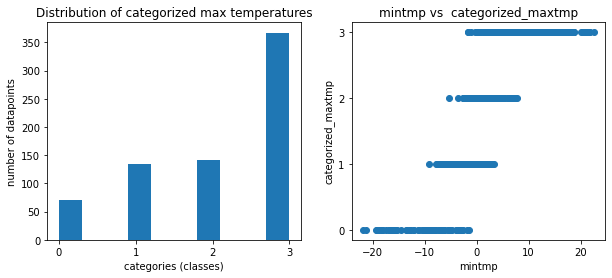

In [20]:
# visualize the distribution of categorized max temperature
# visualize mintmp vs categorized maxtmp
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(FMIRawData['categorized max temperature']) 
axes[0].set_xticks([0,1,2,3])
axes[0].set_xlabel("categories (classes)")
axes[0].set_ylabel("number of datapoints")
axes[0].set_title("Distribution of categorized max temperatures")

axes[1].scatter(FMIRawData['min temperature'],FMIRawData['categorized max temperature']);
axes[1].set_xlabel("mintmp")
axes[1].set_ylabel("categorized_maxtmp")
axes[1].set_yticks([0,1,2,3])
axes[1].set_title("mintmp vs  categorized_maxtmp")

In [21]:
## create the feature matrix X_multi from the column "min temperature", make sure X_multi.shape==(m,1)
## create label vector y_multi from 'categorized max temperature' column, y_multi.shape==(m,)

# YOUR CODE HERE
X_multi = np.array(FMIRawData['min temperature']).reshape(FMIRawData.shape[0],1)
y_multi = np.array(FMIRawData['categorized max temperature']).reshape(FMIRawData.shape[0],)

#sanity check the shape of the feature matrix and the label vector
assert X_multi.shape == (FMIRawData.shape[0],1), "feature matrix shape error"
assert y_multi.shape == (FMIRawData.shape[0],),"label vector shape error"

In [22]:
## create a LogisticRegressor and train it
## NOTE: please carefully check variable names, DO NOT overwrite variable names used in A3.1

# YOUR CODE HERE
clf_2 = LogisticRegression(random_state=0)           # initialise a LogisticRegression classifier, use default value for all arguments
clf_2.fit(X_multi, y_multi)               # fit the model to the data  
y_multi_pred = clf_2.predict(X_multi)    # compute predicted labels for training datapoints
multi_accuracy = clf_2.score(X_multi, y_multi)  #compute accuracy on the training set


## sanity check
assert isinstance(clf_2, LogisticRegression), "please use LogisticRegression model"
assert np.isclose(clf_2.coef_[0],-0.79953543), "learnt parameters are incorrect, please check the feature and label"
assert y_multi_pred[0] == 1, "prediction error, please check the feature"
print("accuracy of multi classification : ", multi_accuracy)

accuracy of multi classification :  0.7489481065918654


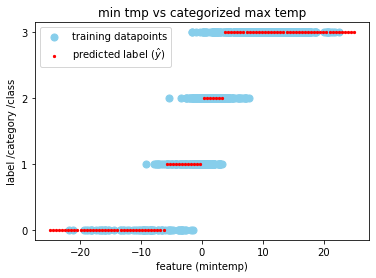

In [23]:
# plot results
# when plotting a single plot, we can omit creating a figure object
plt.scatter(X_multi[:,0],y_multi,s=50,c="skyblue",label="training datapoints")

X_fit = np.linspace(-25, 25, 100) 
plt.scatter(X_fit, clf_2.predict(X_fit.reshape(-1, 1)),color='red',s=5,label="predicted label ($\hat{y}$)") 

plt.xlabel("feature (mintemp)")
plt.ylabel("label /category /class")
plt.yticks([0,1,2,3])
plt.title("min tmp vs categorized max temp")
plt.legend()
plt.show()

In [24]:
# this cell is for tests

<div class=" alert alert-warning">

# Student Task A3.5 

Answer the following quiz questions by setting the corresponding variable to the index of the answer that you consider correct.
    
Question 1: Consider a classification problem with 5 classes whose frequency is 150, 250, 200, 300, 100. Is there a hypothesis map that can achieve an accuracy of at least 10 percent? 

 - Answer 1: Yes
    
 - Answer 2: No
    

Question 2: Consider a multiclass classifcation problem with 10 classes for which we have found a classifier that achives 70 percent accuracy. Now consider a simplified problem that is obtained by combining 4 classes into one single new class. Can we be sure to find a classifier for this new problem that achieves at least 70 percent accuracy?
  
 - Answer 1: Yes
    
 - Answer 2: No



</div >

In [25]:

## set Answer_Q1 to the index of the correct answer (e.g., Answer_Q1=1 if you think Answer 1 is correct)

Answer_Q1  = 2
Answer_Q2 = 2


In [26]:
# sanity check datatype of Answer_Q1
assert isinstance(Answer_Q1, int), "Please use datatype 'int' for your answer"

In [ ]:
# this cell is for tests